<a href="https://colab.research.google.com/github/CUOTR/PYTHON_Credit_Rating_Performance/blob/main/Credit_Rating_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PYTHON: CREDIT RATING PERFORMANCE**


# **Overview**

This project analyzes a  consumer loan dataset from KAGGLE  to evaluate the performance of the internal credit rating system (`sub_grade`).

The main objective is to assess whether the rating grades (from A1 to G5) effectively discriminate credit risk by examining actual

(`default rates`)(Charged Off loans) across different grades.

# I. EXTRACT, TRANSFORM, LOAD (ETL)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/CREDIT_RATING.csv")

print(df.isnull().sum())
print(df.describe())
print(df.info())

id                        0
address_state             0
emp_length                0
emp_title              1087
home_ownership            0
loan_status               0
member_id                 0
purpose                   0
sub_grade                 0
term                      0
verification_status       0
annual_income             0
dti                       0
installment               0
int_rate                  0
loan_amount               0
total_acc                 0
total_payment             0
dtype: int64
                 id     member_id  annual_income           dti   installment  \
count  3.196300e+04  3.196300e+04   3.196300e+04  31963.000000  31963.000000   
mean   7.337336e+05  9.201666e+05   7.012571e+04      0.135312    329.247058   
std    1.858260e+05  2.211054e+05   6.488187e+04      0.066511    210.883700   
min    5.724500e+04  7.069900e+04   4.080000e+03      0.000000     16.250000   
25%    5.843730e+05  7.504905e+05   4.200000e+04      0.084400    169.780000   
50%

In [ ]:
cols = ['annual_income', 'dti', 'loan_amount', 'installment']

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print("Before:", len(df))

df_clean = df.copy()
for col in cols:
    df_clean = remove_outliers(df_clean, col)

print("After:", len(df_clean))
print("Revmoved:", len(df) - len(df_clean), "outliers")

df = df_clean

Before: 28817
After: 28131
Revmoved: 686 outliers


In [ ]:
df.drop(columns=['emp_title'], inplace=True)

df['loan_term'] = df['term'].str.extract(r'(\d+)').astype(float).astype(int)

df['grade'] = df['sub_grade'].str[0]

df.drop(columns=['term'], inplace=True)
df.head(1)

,id,address_state,emp_length,home_ownership,loan_status,member_id,purpose,sub_grade,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment,loan_term,grade
0,1068350,IL,10+ years,MORTGAGE,Fully Paid,1302971,car,A1,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835,36,A


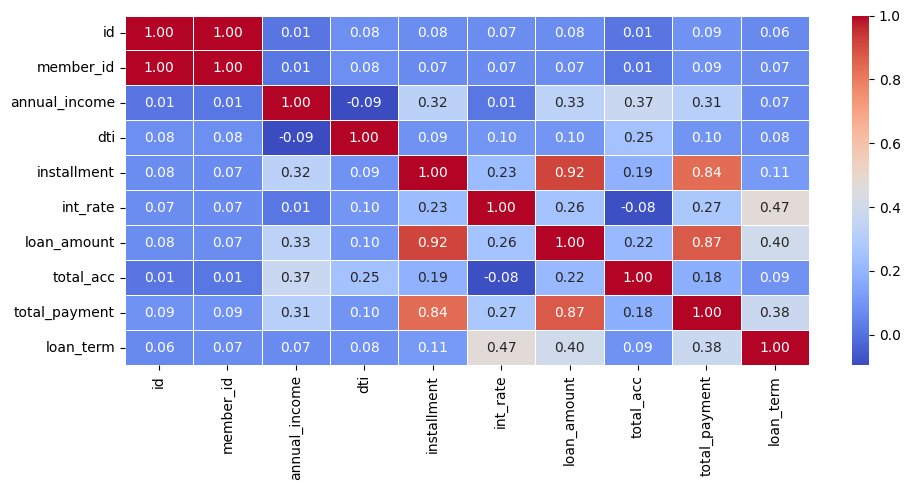

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.show()


# II. EXPLORATORY DATA ANALYSIS (EDA)

1. DEFAULT LOANS

In [ ]:
df['expected_total'] = df['loan_term'] * df['installment']

completed_loans = df[df['loan_status'] != 'Current']

total_expected_completed = completed_loans['expected_total'].sum()
total_actual_completed = completed_loans['total_payment'].sum()
total_loss_completed = total_expected_completed - total_actual_completed
loss_rate_completed = total_loss_completed / total_expected_completed

charged_off = df[df['loan_status'] == 'Charged Off']

total_expected_co = charged_off['expected_total'].sum()
total_actual_co = charged_off['total_payment'].sum()
total_loss_co = total_expected_co - total_actual_co
lgd = total_loss_co / total_expected_co

pd_rate = len(charged_off) / len(completed_loans)

print("Loan status distribution:")
print(df['loan_status'].value_counts())

print("\n=== On completed loans (Fully Paid + Charged Off) ===")
print(f"Total expected payment: {total_expected_completed:,.2f} USD")
print(f"Total actual payment received: {total_actual_completed:,.2f} USD")
print(f"Total loss: {total_loss_completed:,.2f} USD")
print(f"Overall loss rate: {loss_rate_completed:.2%}")

print("\n=== Charged Off loans ===")
print(f"Total expected payment: {total_expected_co:,.2f} USD")
print(f"Total recovered amount: {total_actual_co:,.2f} USD")
print(f"Total loss: {total_loss_co:,.2f} USD")
print(f"Loss Given Default (LGD): {lgd:.2%}")
print(f"Probability of Default (PD): {pd_rate:.2%}")

Loan status distribution:
loan_status
Fully Paid     23899
Charged Off     4008
Current          910
Name: count, dtype: int64

=== On completed loans (Fully Paid + Charged Off) ===
Total expected payment: 348,443,660.28 USD
Total actual payment received: 302,883,148.00 USD
Total loss: 45,560,512.28 USD
Overall loss rate: 13.08%

=== Charged Off loans ===
Total expected payment: 57,988,317.12 USD
Total recovered amount: 25,425,200.00 USD
Total loss: 32,563,117.12 USD
Loss Given Default (LGD): 56.15%
Probability of Default (PD): 14.36%


Loan portfolio of 31,963 loans

Probability of Default (PD): 14.36% – significantly higher than typical industry average (usually 5-10%).

Loss Given Default (LGD): 56.15% –  indicating weak Debt Collection Process.

Overall loss rate: 13.68% on completed loans; minor losses in Fully Paid are mainly from prepayment and rounding, not credit risk.

Expected Loss (EL = PD × LGD): ≈ 8.07% – average anticipated loss per loan.

In [ ]:
income = pd.crosstab(df['loan_status'],
                            pd.cut(df['annual_income'], [0,50000,80000,float('inf')],
                                   labels=['low (<50k)', 'Med (50-80k)', 'Hig (>80k)']),
                            normalize='index') * 100
income = income.round(2).astype(str) + '%'
print("Income level (%):")
print(income)

dti = pd.crosstab(df['loan_status'],
                       pd.cut(df['dti'], [0,0.1,0.2,1],
                              labels=['low (<10%)', 'Med (10-20%)', 'Hig (>20%)']),
                       normalize='index') * 100
dti = dti.round(2).astype(str) + '%'
print("\nDTI levles (%):")
print(dti)

Income level (%):
annual_income low (<50k) Med (50-80k) Hig (>80k)
loan_status                                     
Charged Off       49.38%       35.78%     14.85%
Current           35.82%        38.9%     25.27%
Fully Paid        41.03%       36.76%     22.21%

DTI levles (%):
dti         low (<10%) Med (10-20%) Hig (>20%)
loan_status                                   
Charged Off     27.03%       50.63%     22.34%
Current         24.06%       47.57%     28.37%
Fully Paid      31.99%       48.43%     19.57%


Risks are typically concentrated in the low-income and moderate-DTI segments, reflecting limited financial capacity.

Current loans show a broader distribution across high-income and high-DTI groups, indicating superior repayment potentials compared to the default group.


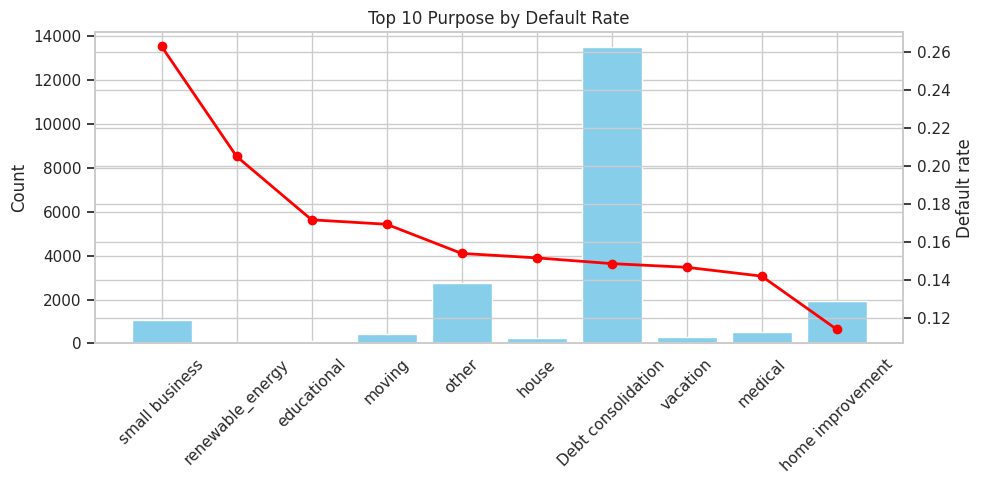

In [ ]:
import matplotlib.pyplot as plt

df['is_default'] = df['loan_status'] == 'Charged Off'

purpose = df.groupby('purpose').agg(
    total_loans=('is_default', 'size'),
    default_rate=('is_default', 'mean')
).reset_index()

top10 = purpose.sort_values('default_rate', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(top10['purpose'], top10['total_loans'], color='skyblue')
ax1.set_ylabel('Count')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(top10['purpose'], top10['default_rate'], color='red', marker='o', linewidth=2)
ax2.set_ylabel('Default rate')

plt.title('Top 10 Purpose by Default Rate')
plt.tight_layout()
plt.show()

Small Business loans are the riskiest. Despite the high risk, the volume of these loans remains relatively low.

Debt Consolidation has the highest volume, making it the primary driver of business scale.

Home Improvement is the most safe category. These borrowers are the most creditworthy.

2. GRADE / SUB_GRADE

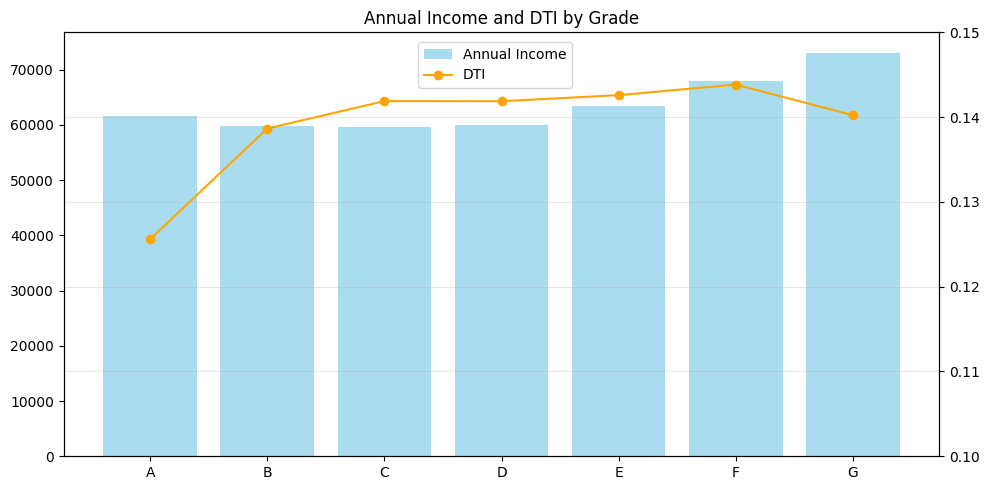

In [ ]:
summary = df.groupby('grade')[['annual_income', 'dti']].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(summary.index, summary['annual_income'], color='skyblue', alpha=0.7, label='Annual Income')

ax2 = ax1.twinx()
ax2.plot(summary.index, summary['dti'], color='orange', marker='o', label='DTI')
ax2.set_ylim(0.1, 0.15)

plt.title('Annual Income and DTI by Grade')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The higher income, The more they tend to borrow.

Risk is not solely determined by income: Looking at Grades B, C, and D, even though their income is lower than Grade G, they maintain better credit ratings because their DTI is lower.

This DTI carries more weight than total income when assessing creditworthiness.

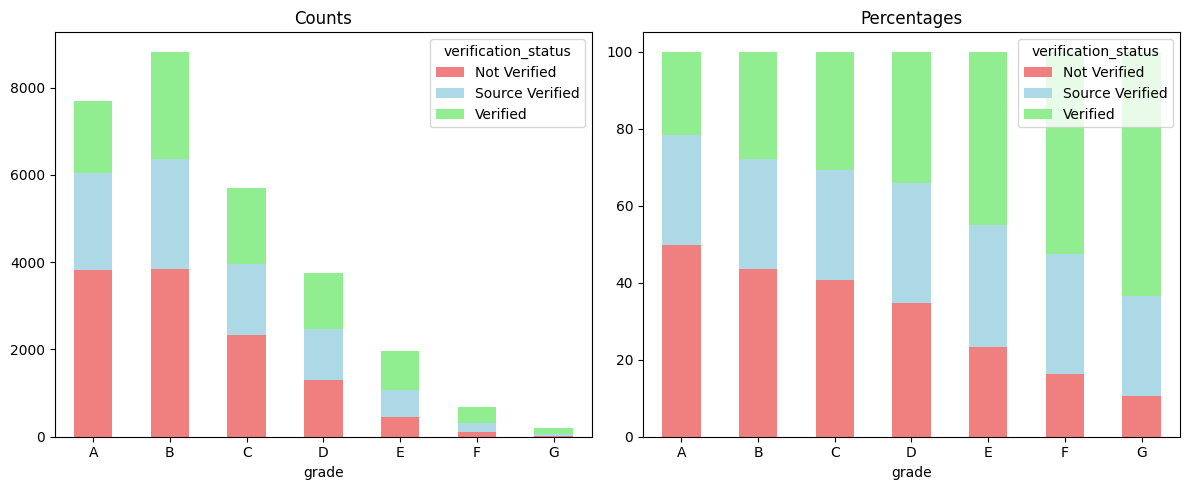

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

count = pd.crosstab(df['grade'], df['verification_status'])
percent = pd.crosstab(df['grade'], df['verification_status'], normalize='index') * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = ['lightcoral', 'lightblue', 'lightgreen']

count.plot.bar(stacked=True, color=colors, ax=ax1)
percent.plot.bar(stacked=True, color=colors, ax=ax2)

ax1.set_title('Counts')
ax2.set_title('Percentages')
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

The lender applies stricter verification to riskier borrowers.

As grades deteriorate from A to G, the proportion of fully Verified loans rises significantly, indicating effective risk-based underwriting.

The small volume in E–G combined with heavy verification suggests cautious exposure to subprime segments.


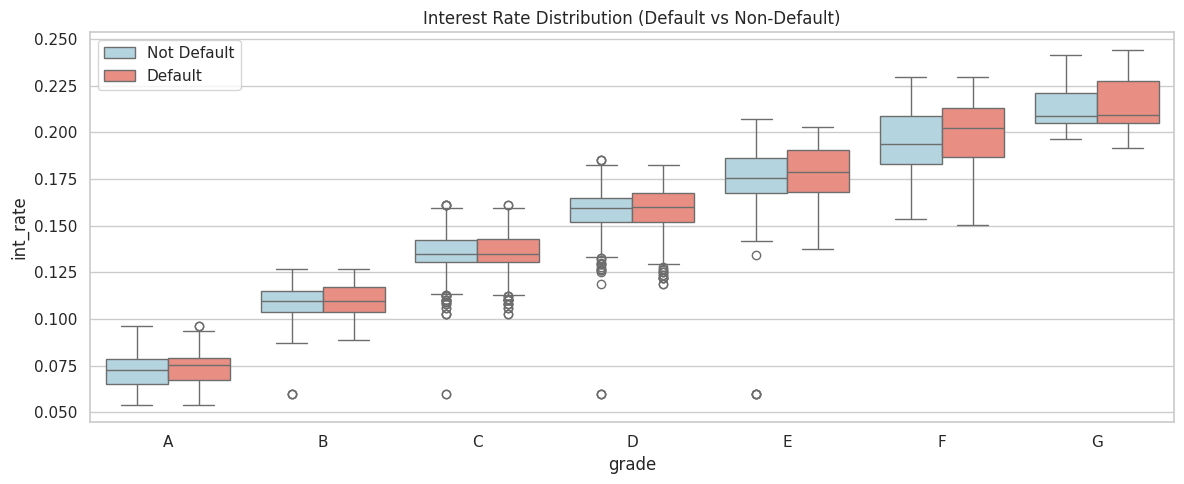

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

df['is_default'] = df['is_default'].astype(int)
ax = sns.boxplot(data=df, x='grade', y='int_rate',
    hue='is_default',
    palette={0: 'lightblue', 1: 'salmon'},
)
plt.title('Interest Rate Distribution (Default vs Non-Default)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Not Default', 'Default'])
plt.tight_layout()
plt.show()

Positive correlation between risk and interest rate: Higher Rates for defaulted loans.

High volatility in lower grades: Lower credit tiers (F and G).
This indicates a lack of stability and higher risk premium in pricing loans for these segments.

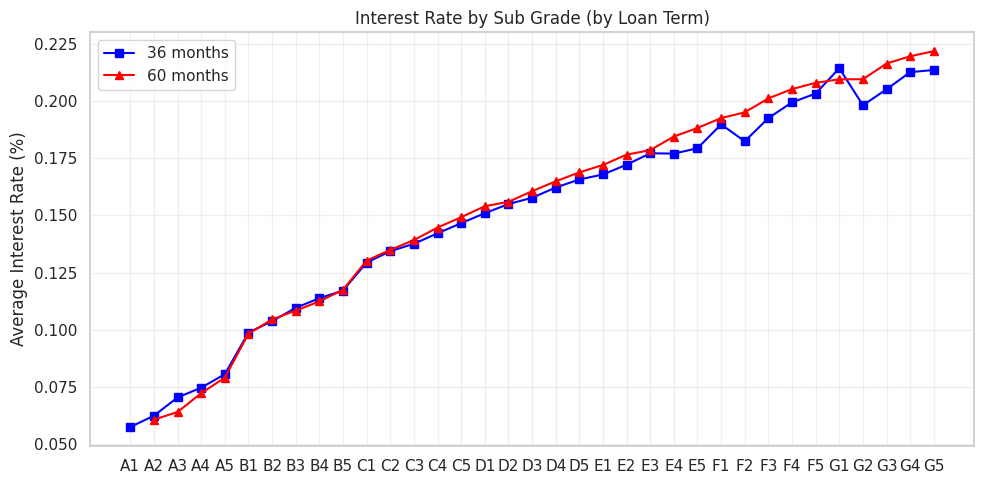

In [ ]:
import matplotlib.pyplot as plt

int_36 = df[df['loan_term'] == 36].groupby('sub_grade')['int_rate'].mean()
int_60 = df[df['loan_term'] == 60].groupby('sub_grade')['int_rate'].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(int_36.index, int_36.values, marker='s', label='36 months', color='blue')
ax1.plot(int_60.index, int_60.values, marker='^', label='60 months', color='red')

ax1.set_title('Interest Rate by Sub Grade (by Loan Term)')
ax1.set_ylabel('Average Interest Rate (%)')
ax1.legend()
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

A-B: A1-B5 (Low Risk): Clear ending-gaps between grades show precise risk pricing. Interest rates remain the same regardless of the loan term.

C1-E3 (Moderate Risk): Risk increases gradually. There are no gaps between sub-grades, and interest rates rise when choosing a longer loan term.

E4-G5 (High Risk): Interest rates behave abnormally. This suggests the scoring model is struggling to accurately determine interest rates at this high-risk level.

3. DEFAULT RATE BY SUB_GRADE

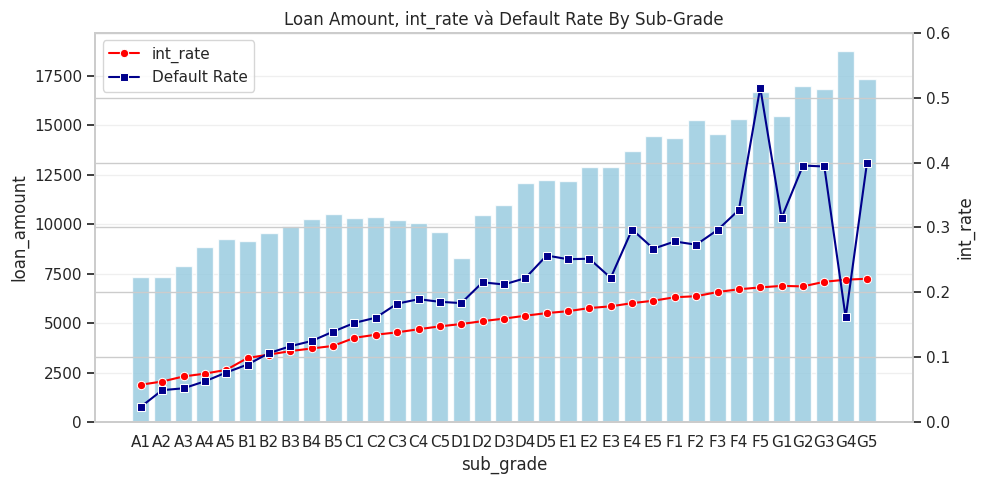

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

subgrade = df.groupby('sub_grade').agg({'loan_amount': 'mean','int_rate': 'mean','is_default': 'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.barplot(data=subgrade, x='sub_grade', y='loan_amount', color='skyblue', alpha=0.8, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=subgrade, x='sub_grade', y='int_rate', color='red', marker='o', label='int_rate', ax=ax2)
sns.lineplot(data=subgrade, x='sub_grade', y='is_default', color='darkblue', marker='s', label='Default Rate', ax=ax2)
ax2.set_ylim(0, 0.6)

ax1.set_title('Loan Amount, int_rate và Default Rate By Sub-Grade')
ax1.grid(axis='y', alpha=0.3)
lines1 = ax1.get_legend_handles_labels()
lines2 = ax2.get_legend_handles_labels()

plt.tight_layout()
plt.show()

Consistent Risk-Based Pricing

The Interest Rate increases linearly in alignment with the sub-grades. This shows a disciplined pricing strategy where higher risks are systematically offset by higher premiums.

Grades A - D

The grading system is highly effective in its primary role. The Default Rate increases consistently, proving that the scoring criteria accurately reflect creditworthiness.

Grades E - G

Volatility: In the lowest grades (F & G), the Default Rate becomes volatile rather than steadily increasing. This suggests the grading scale loses predictive stability at the extreme end

Combining high default rates with larger loan amount creates a high-exposure zone for the lender.

# III. RECOMMENDATIONS

* Defaulted Loans / Default Rate:

Focus on improving the lending process, emphasizing debt recovery capabilities, especially low-income.

Implement appropriate policies for each group to reduce the default rate.

* Grade

Tighten lending criteria, ensure even stricter verification processes.

Create a standard interest rate framework for each ranking level.

* Scale

Only effective when risk is low

Add new criteria to improve the scale: Payment history, Transaction history, ... or switch to a point-based format to enhance quality.

